<center>
    <h1>Model : EfficientNet B0</h1>
</center>

After compared different models inside the notebook `notebooks/models/pab-model_comparison.ipynb`, we will focus on the chosen one : EfficientNet B0. We will train the model and try to improve it, particularly regarding overfitting issues.

<table align="left">
    <td>
        <a href="https://colab.research.google.com/github/dailoht/Epitech_Zoidberg2.0/blob/main/notebooks/models/pab-efficientnet_b0.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
    </td>
</table>

# 1. Setup

In this section, we setup the notebook by :
 - Import useful external libraries such that numpy, pandas, tensorflow, ...
 - ⚠️⚠️⚠️ Manage Colab and tensorflow strategy : we will use Google Drive as storage when using colab, so becareful to change project folder path in your drive).
 - Import personal modules (from `src` folder).
 - Set default visualization for awesome graphics !
 - Set default seed to replicate specific behavior implying random numbers.

In [1]:
# Import base librairies
import sys
import os
import json
from pathlib import Path
import time

# Import scientific librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import Tensorflow and Keras
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score
# Check running environment
try:
    from google.colab import drive
    IN_COLAB=True
except:
    IN_COLAB=False

if IN_COLAB:
    print("We're running on Colab")
    
    # Install tensorflow-addons
    !pip install tensorflow_addons
    
    # Mount google drive
    mounting_point = "/content/drive/"
    drive.mount(mounting_point, force_remount=True)

    # Add project directory to kernel paths
    drive_folder = "MyDrive/Etudes/Epitech/MSc/MSc-1/Zoidberg_AI/T-DEV-810-PAR_10"
    sys.path.append(mounting_point + drive_folder)
else:
    print("We're running localy")
    
    # Add project directory to kernel paths
    sys.path.append('../..')

2023-05-22 04:36:25.340730: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We're running localy


In [2]:
# Import custom functions
from src.visualization.plot_lib import default_viz
from src.data.file_manager import FileManager
from src.data.tf_utils import load_image_dataset_from_tfrecord, define_distribute_strategy
from src.data.evaluation import Evaluation

zoidbergManager = FileManager()
strategy = define_distribute_strategy()
evaluation = Evaluation(strategy)

# Set default graphics visualization
%matplotlib inline
default_viz()

Selected distribution strategy:                     _DefaultDistributionStrategy


2023-05-22 04:36:29.834629: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# set random seed for keras, numpy, tensorflow, and the 'random' module
SEED = 42
tf.keras.utils.set_random_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# 2. Loading dataset

First we define the batch size. Its value has been chosen as it is the highest one without reaching RAM upper bound.

In [4]:
BATCH_SIZE = 64

Let's now load the train and val datasets, one can see the argument `prefetch=True` which means that we shuffle, batch et prefetch data after loading. Prefetch data allows Tensorflow to preprocess and preload data in parallel of training i.e when batch $n$ is trained, batch $n+1$ is preloaded.

In [5]:
processed_dir_path = zoidbergManager.data_dir / 'processed'

train_path = str(processed_dir_path / 'train_512x512_rgb_ds.tfrecord')
val_path = str(processed_dir_path / 'val_512x512_rgb_ds.tfrecord')

train_ds = load_image_dataset_from_tfrecord(train_path, prefetch=True, batch_size=BATCH_SIZE)
val_ds = load_image_dataset_from_tfrecord(val_path, prefetch=True, batch_size=BATCH_SIZE)

# 3. Train the model

In this section, we define the model, define how it will trained and train it.

⚠️⚠️⚠️ WARNING : Depending on your hardware, training cells can be computationally expensive and take a really long time to run them !!!  
That's why each of these cells are wrapped in a *if condition* (see `TRAIN_*MODEL*` booleans below).

In [6]:
TOP_TRAIN_EPOCHS = 20
FINE_TUNE_EPOCHS = 200
LEARNING_RATE = 1e-4

TRAIN_EFFICIENTNETB0_V1 = False
TRAIN_EFFICIENTNETB0_V2 = False

## 3.1 Preparation before training

We define 3 callbacks which will be called during training :
 - checkpoint callback : save model after each epoch. More precisely, it saves only best model (i.e best epoch regarding Matthew coef. on validation set).
 - learning rate plateau callback : Decrease learning rate if the model is no longer making progress.
 - early stopping : Stop training when model is no longer making progress (it is more constraint than lr plateau). 

In [7]:
def checkpoint_cb(model, version):
    checkpoint_dir = zoidbergManager.model_dir / 'checkpoints'
    checkpoint_filepath = checkpoint_dir / f'ckpt_{model.name}_v{version}.h5'
    ckpt_cb = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_MCC',
        mode='max',
        save_best_only=True
    )
    return ckpt_cb

def lr_plateau_cb():
    plateau_cb = keras.callbacks.ReduceLROnPlateau(
        monitor='val_MCC',
        mode='max',
        factor=0.2,
        patience=5,
        min_lr=1e-7,
    )
    return plateau_cb

def early_stopping_cb():
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='MCC',
        mode='max',
        patience=5,
        min_delta=1e-7,
        restore_best_weights=True,
    )
    return early_stopping

As we saw when analyzing data, classes are imbalanced. Thus, we load class weight to prevent this issue :

In [8]:
class_weights_filepath = zoidbergManager.model_dir / 'class_weights.json'

with open(class_weights_filepath) as file:
        class_weights_json = json.load(file)
class_names = class_weights_json['names']
class_weights = class_weights_json['weights']

dic_class_weights = {}
for idx, weight in enumerate(class_weights):
    dic_class_weights[idx] = weight
    print(f'class {class_names[idx]} => weight : {weight:2f}')

class bacteria => weight : 0.696393
class normal => weight : 1.241696
class virus => weight : 1.318080


Then we create 2 functions. One to save model history with it's learning rate, Matthew coef. and loss function. The other one wrap the fitting method.

In [9]:
def save_history(model, version, history):
    history.history['lr'] = [float(lr) for lr in history.history['lr']]
    
    history_dir = zoidbergManager.model_dir / 'histories'
    history_filepath = history_dir / f'hty_{model.name}_v{version}.json'
    json.dump(history.history, open(history_filepath, 'w'))

def train_model(model, version, epochs, callbacks=None, save=False):
    history = model.fit(train_ds,
                        validation_data=val_ds,
                        epochs=epochs,
                        class_weight=dic_class_weights,
                        callbacks=callbacks,
                        )

    if save:
        save_history(model, version, history)

    return history

Finally, we define the input layer and top layers (thoses at the end which will return class probabilities).

In [10]:
input_layers = keras.layers.InputLayer(input_shape=(512,512,3), name='input')

top_layers = keras.Sequential([
    keras.layers.GlobalAveragePooling2D(name='avg_pool'),
    keras.layers.Dense(256, activation='relu', name='fully_conn1'),
    keras.layers.Dense(3, activation='softmax', name='out_softmax'),
], name='top_layers')

## 3.2 Training

### A. Model definition

Let's define the model !
Our model is EfficientNet B0 which ingests images of size $224\times 224$. That's why we resize image. However, instead of many other models, it does not want normalized images !

In [11]:
def make_efficientnetb0(input_layers=input_layers, top_layers=top_layers):
    base_efficientnetb0 = tf.keras.applications.EfficientNetV2B0(weights='imagenet', input_shape=(224,224,3), include_top=False)
    for layer in base_efficientnetb0.layers:
        layer.trainable = False
    
    efficientnetb0 = tf.keras.Sequential([
        input_layers,
        keras.layers.Resizing(224, 224, interpolation="bilinear", name='resize'),
        base_efficientnetb0,
        top_layers,
    ], name = 'efficientnetb0')

    efficientnetb0.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss='categorical_crossentropy',
                  metrics=evaluation.get_training_metrics()
                 )
    return efficientnetb0
    
with strategy.scope():
    efficientnetb0_v1 = make_efficientnetb0()

### B. Training

When we use transfer learning with top layers that we have defined ourselves, it is useful to train these top layers first before training the entire model. This approach allows the top layers to specialize and adapt to the specific task or dataset at hand while leveraging the pre-trained weights of the base model, which typically captures general features from a large dataset. By training the top layers first, we can optimize them to better align with the specific task, and then proceed with fine-tuning the entire model if necessary.

That's why the train cell below is divide in 2 parts.

In [12]:
if TRAIN_EFFICIENTNETB0_V1:
    print('----- Train Top -----')
    history = train_model(efficientnetb0_v1,
                version=1,
                epochs=TOP_TRAIN_EPOCHS,
                callbacks=[lr_plateau_cb(),early_stopping_cb()],
                save=False)
    
    for layer in efficientnetb0_v1.get_layer(name='efficientnetv2-b0').layers:
        layer.trainable = True

    efficientnetb0_v1.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                           loss='categorical_crossentropy',
                           metrics=evaluation.get_training_metrics()
                           )

    print('----- Train Full -----')
    efficientnetb0_history_v1 = train_model(efficientnetb0_v1,
                                         version=1,
                                         epochs=FINE_TUNE_EPOCHS,
                                         callbacks=[
                                             checkpoint_cb(efficientnetb0_v1,version=1),
                                             lr_plateau_cb(),
                                             early_stopping_cb()
                                         ],
                                         save=True)

### C. Result

We can now check training result by displaying learning curves :

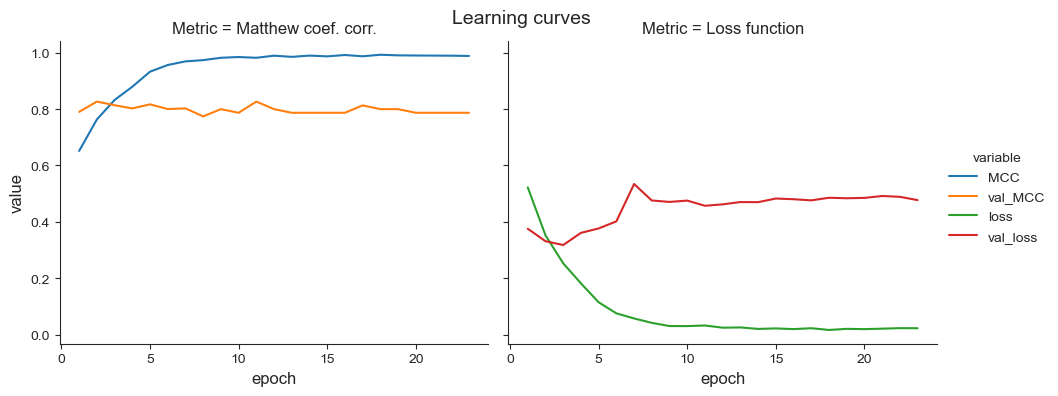

In [13]:
hty_model_v1_path = zoidbergManager.model_dir / 'histories' / 'hty_efficientnetb0_v1.json'
with open(hty_model_v1_path) as file:
        hty_effnetb0_v1_df = pd.DataFrame(json.load(file))

hty_effnetb0_v1_df = hty_effnetb0_v1_df[['MCC','val_MCC','loss','val_loss']]
hty_effnetb0_v1_df['epoch'] = np.arange(1,hty_effnetb0_v1_df.shape[0]+1)
hty_effnetb0_v1_df = pd.melt(hty_effnetb0_v1_df,['epoch'])

def assign_metric(row):
    if row['variable'] == 'loss' or row['variable'] == 'val_loss':
        return 'Loss function'
    else:
        return 'Matthew coef. corr.'

hty_effnetb0_v1_df['Metric'] = hty_effnetb0_v1_df.apply(lambda row: assign_metric(row), axis=1)

sns.set_style('ticks')
rp = sns.relplot(
    data=hty_effnetb0_v1_df,
    x="epoch",
    y="value",
    hue="variable",
    col="Metric",
    col_wrap=2,
    height=4,
    aspect=1.2,
    kind="line"
)
rp.fig.suptitle('Learning curves', fontsize=14)
rp.fig.subplots_adjust(top=0.9)

plt.savefig(zoidbergManager.resource_dir / 'effnetv1_learning_curves.png')

Not that bad ! We converge really fast (less than 30 epochs) and reach Matthew coef. reachs a high value (close to 1). However, we get a big gap between train and validation set i.e we get overfitting ...
The main cause of overfitting in this scenario can be attributed to the model's complexity relative to the scarcity of available data. This happens because the model has more capacity to memorize the training examples rather than learn meaningful and generalizable representations.

## 3.3 Handling overfitting

In this section, we will handle overfitting by using :
 - Data augmentation : applying various transformations and modifications to existing image data to create augmented versions of the original images. Here, we apply *Zoom*, *Translation* and *Rotation*.
 - Dropout : randomly "dropping out" (i.e., deactivating) a fraction of the neurons in the neural network during training.
 - $L_1$-regularization (Lasso regularization) : introduce a penalty term ( proportional to the sum of the absolute values of the model's parameters) that encourages sparse solutions.

### A. Data augmentation

Data augmentation can be used by adding transformation layer before convolutional layers : 

In [14]:
data_augmentation = keras.Sequential([
    input_layers,
    keras.layers.RandomZoom(height_factor=0.1, name='zoom'),
    keras.layers.RandomTranslation(height_factor=0.1,
                                   width_factor=0.1,
                                   name='translation'),
    keras.layers.RandomRotation(factor=0.1, name='rotation'),
], name='data_augmentation')

Let's just check an example of what these transformations do :

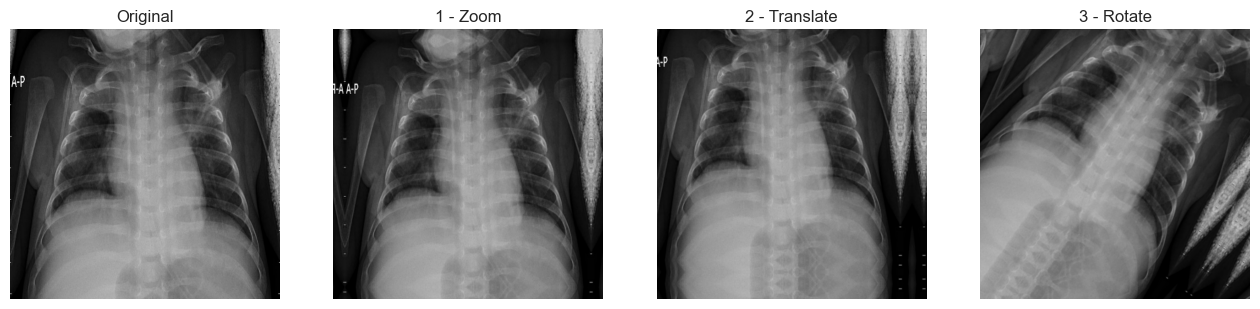

In [15]:
image = next(iter(train_ds.take(1)))[0][0]

tf.keras.backend.clear_session()

zoom = data_augmentation.get_layer(name='zoom')
translation = data_augmentation.get_layer(name='translation')
rotation = data_augmentation.get_layer(name='rotation')

zm_image = np.array(zoom(image).numpy()).astype(np.int64)
trs_image = np.array(translation(zm_image).numpy()).astype(np.int64)
rot_image = np.array(rotation(trs_image).numpy()).astype(np.int64)

fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(16,5))
for i in range(4):
    axes[i].set_axis_off()

axes[0].imshow(image)
axes[0].set_title('Original')
axes[1].imshow(zm_image)
axes[1].set_title('1 - Zoom')
axes[2].imshow(trs_image)
axes[2].set_title('2 - Translate')
axes[3].imshow(rot_image)
axes[3].set_title('3 - Rotate')

plt.savefig(zoidbergManager.resource_dir / 'data_augmentation.png')

### B. Dropout & L1-regularization

Then, we redefine top layers to add dropout and Lasso :

In [16]:
top_layers_dropout = keras.Sequential([
    keras.layers.GlobalAveragePooling2D(name='avg_pool'),
    keras.layers.Dropout(rate=0.7, name='top_dropout_1'),
    keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01), name='fully_conn1'),
    keras.layers.Dropout(rate=0.5, name='top_dropout_2'),
    keras.layers.Dense(3, activation='softmax', name='out_softmax'),
], name='top_layers')

### C. Training

Let's start over and train this new model :

In [17]:
with strategy.scope():
    efficientnetb0_v2 = make_efficientnetb0(input_layers=data_augmentation, top_layers=top_layers_dropout)

In [18]:
if TRAIN_EFFICIENTNETB0_V2:
    print('----- Train Top -----')
    history = train_model(efficientnetb0_v2,
                version=2,
                epochs=TOP_TRAIN_EPOCHS,
                callbacks=[lr_plateau_cb(),early_stopping_cb()],
                save=False)
    
    for layer in efficientnetb0_v2.get_layer(name='efficientnetv2-b0').layers:
        layer.trainable = True

    efficientnetb0_v2.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                           loss='categorical_crossentropy',
                           metrics=evaluation.get_training_metrics()
                           )

    print('----- Train Full -----')
    efficientnetb0_history_v2 = train_model(efficientnetb0_v2,
                                         version=2,
                                         epochs=FINE_TUNE_EPOCHS,
                                         callbacks=[checkpoint_cb(efficientnetb0_v2,version=2),
                                                    lr_plateau_cb(),
                                                    early_stopping_cb()
                                                  ],
                                         save=True)

### D. Result

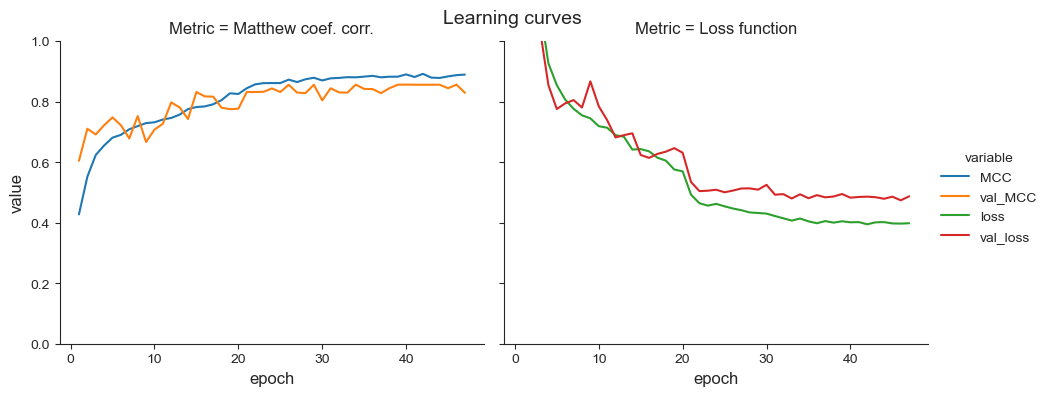

In [19]:
hty_model_v2_path = zoidbergManager.model_dir / 'histories' / 'hty_efficientnetb0_v2.json'
with open(hty_model_v2_path) as file:
        hty_effnetb0_v2_df = pd.DataFrame(json.load(file))

hty_effnetb0_v2_df = hty_effnetb0_v2_df[['MCC','val_MCC','loss','val_loss']]
hty_effnetb0_v2_df['epoch'] = np.arange(1,hty_effnetb0_v2_df.shape[0]+1)
hty_effnetb0_v2_df = pd.melt(hty_effnetb0_v2_df,['epoch'])

hty_effnetb0_v2_df['Metric'] = hty_effnetb0_v2_df.apply(lambda row: assign_metric(row), axis=1)

sns.set_style('ticks')
rp = sns.relplot(
    data=hty_effnetb0_v2_df,
    x="epoch",
    y="value",
    hue="variable",
    col="Metric",
    col_wrap=2,
    height=4,
    aspect=1.2,
    kind="line"
)
plt.ylim(0, 1)
rp.fig.suptitle('Learning curves', fontsize=14)
rp.fig.subplots_adjust(top=0.9)

plt.savefig(zoidbergManager.resource_dir / 'effnetv2_learning_curves.png')

Looking at the new learning curves, we observe that we have successfully reduced overfitting, although there is still a slight gap remaining. 

# 4. Final Results

Finally, let's check result on the test set !

In [20]:
# import test set
test_path = str(processed_dir_path / 'test_512x512_rgb_ds.tfrecord')
test_ds = load_image_dataset_from_tfrecord(test_path)

test_images = []
test_labels = []
for image, label in test_ds:
    test_images.append(image.numpy())
    test_labels.append(label.numpy())
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [21]:
# import model best weights
ckpt_model_path = zoidbergManager.model_dir / 'checkpoints' / f'ckpt_efficientnetb0_v2.h5'

for layer in efficientnetb0_v2.get_layer(name='efficientnetv2-b0').layers:
        layer.trainable = True
efficientnetb0_v2.build(input_shape = (64,512,512,3))
efficientnetb0_v2.load_weights(ckpt_model_path)

In [22]:
# Make predictions on test set
pred_labels = efficientnetb0_v2.predict(test_ds.batch(BATCH_SIZE))

8/8 [==============================] - 11s 1s/step


## 4.1 Classification report

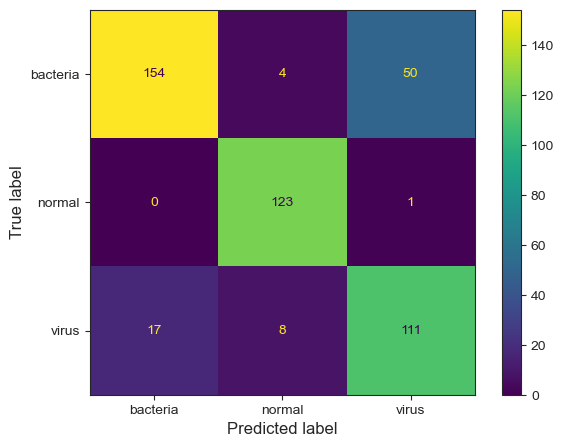

In [23]:
# display confusion matrix
conf_max = evaluation.compute_confusion_matrix(test_labels, pred_labels, display=True)
plt.savefig(zoidbergManager.resource_dir / 'conf_matrix.png')

In [24]:
# display classification report
metrics = evaluation.compute_full_metrics(test_labels, pred_labels, display=True)

               Metrics for each class              
---------------------------------------------------
            Precision    Recall       MCC   Support

  bacteria       0.90      0.74      0.70       208
    normal       0.91      0.99      0.93       124
     virus       0.69      0.82      0.63       136


                   Global metrics                  
---------------------------------------------------
 Precision                                     0.84
    Recall                                     0.83
       MCC                                     0.75
FPR normal                                     0.03
   Support                                      468



Several things are to be observed. First, the overall performance is quite good with a Matthew coef of $0.75$. We can also see that we are very good at distinguishing healthy individuals from those with pneumonia : FPR Normal is $3\%$, and only $1$ image of healthy individuals is misclassified. Our problem lies in distinguishing virus vs. bacteria. Specifically, $1/4$ of bacteria are misclassified as viruses.


Purely for the purpose of comparing this model to others, we aslo calculate its accuracy :

In [25]:
y_true = np.argmax(test_labels, axis=1)
y_pred = np.argmax(pred_labels, axis=1)

y_true_normal = np.where(y_true == 1, 0, 1)
y_pred_normal = np.where(y_pred == 1, 0, 1)

print(f"Global accuracy : {accuracy_score(y_true, y_pred)*100:.2f}%")
print(f"Normal/Pneumonia accuracy : {accuracy_score(y_true_normal, y_pred_normal)*100:.2f}%")

Global accuracy : 82.91%
Normal/Pneumonia accuracy : 97.22%


## 4.2 Visualization

Let's plot an image and check its predicted class :

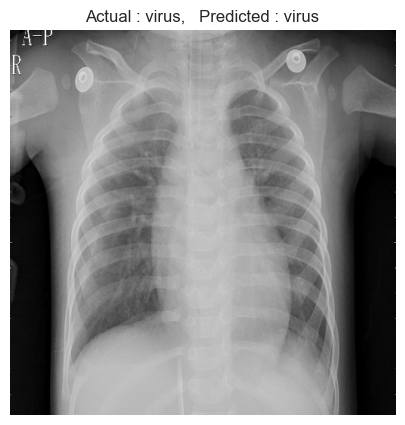

In [26]:
image_idx = 0
plt.imshow(test_images[0])
plt.title(f'Actual : {class_names[y_true[0]]},   Predicted : {class_names[y_pred[0]]}')
axis = plt.axis("off")

Finally, We save our model to use it later in our Flask API :

In [27]:
tf.keras.backend.clear_session()

efficientnetb0_v2.save(zoidbergManager.model_dir / 'final_model.h5')